# パッケージインストール

[CUDA 12 and session.get_providers() not showing CUDAExecutionProvider #21354](https://github.com/microsoft/onnxruntime/issues/21354)

In [ ]:
# !pip install -q onnxruntime-gpu

# #21354暫定対応ここから
!pip install onnxruntime-gpu==1.18.1 --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/  -q
!pip install nvidia-cudnn-cu12==9.2.1.18 nvidia-cuda-runtime-cu12==12.5.82 nvidia-cufft-cu12==11.2.3.61 -q
from ctypes import *
cudnn_libc = cdll.LoadLibrary("/usr/local/lib/python3.10/dist-packages/nvidia/cudnn/lib/libcudnn.so.9")
cublas_libc = cdll.LoadLibrary("/usr/local/lib/python3.10/dist-packages/nvidia/cublas/lib/libcublas.so.12")
cublaslt_libc = cdll.LoadLibrary("/usr/local/lib/python3.10/dist-packages/nvidia/cublas/lib/libcublasLt.so.12")
cudart_libc = cdll.LoadLibrary("/usr/local/lib/python3.10/dist-packages/nvidia/cuda_runtime/lib/libcudart.so.12")
cufft_libc = cdll.LoadLibrary("/usr/local/lib/python3.10/dist-packages/nvidia/cufft/lib/libcufft.so.11")
# #21354暫定対応ここまで

# リポジトリクローン

In [ ]:
!git clone https://github.com/Kazuhito00/CartoonSegmentationOnnx-Colaboratory-Sample

# 重みダウンロード

In [3]:
!wget https://huggingface.co/Jakaline/CartoonSegmentationOnnx/resolve/main/base.onnx -q -O CartoonSegmentationOnnx/models/base.onnx
!wget https://huggingface.co/Jakaline/CartoonSegmentationOnnx/resolve/main/refiner.onnx -q -O CartoonSegmentationOnnx/models/refiner.onnx

# サンプル画像

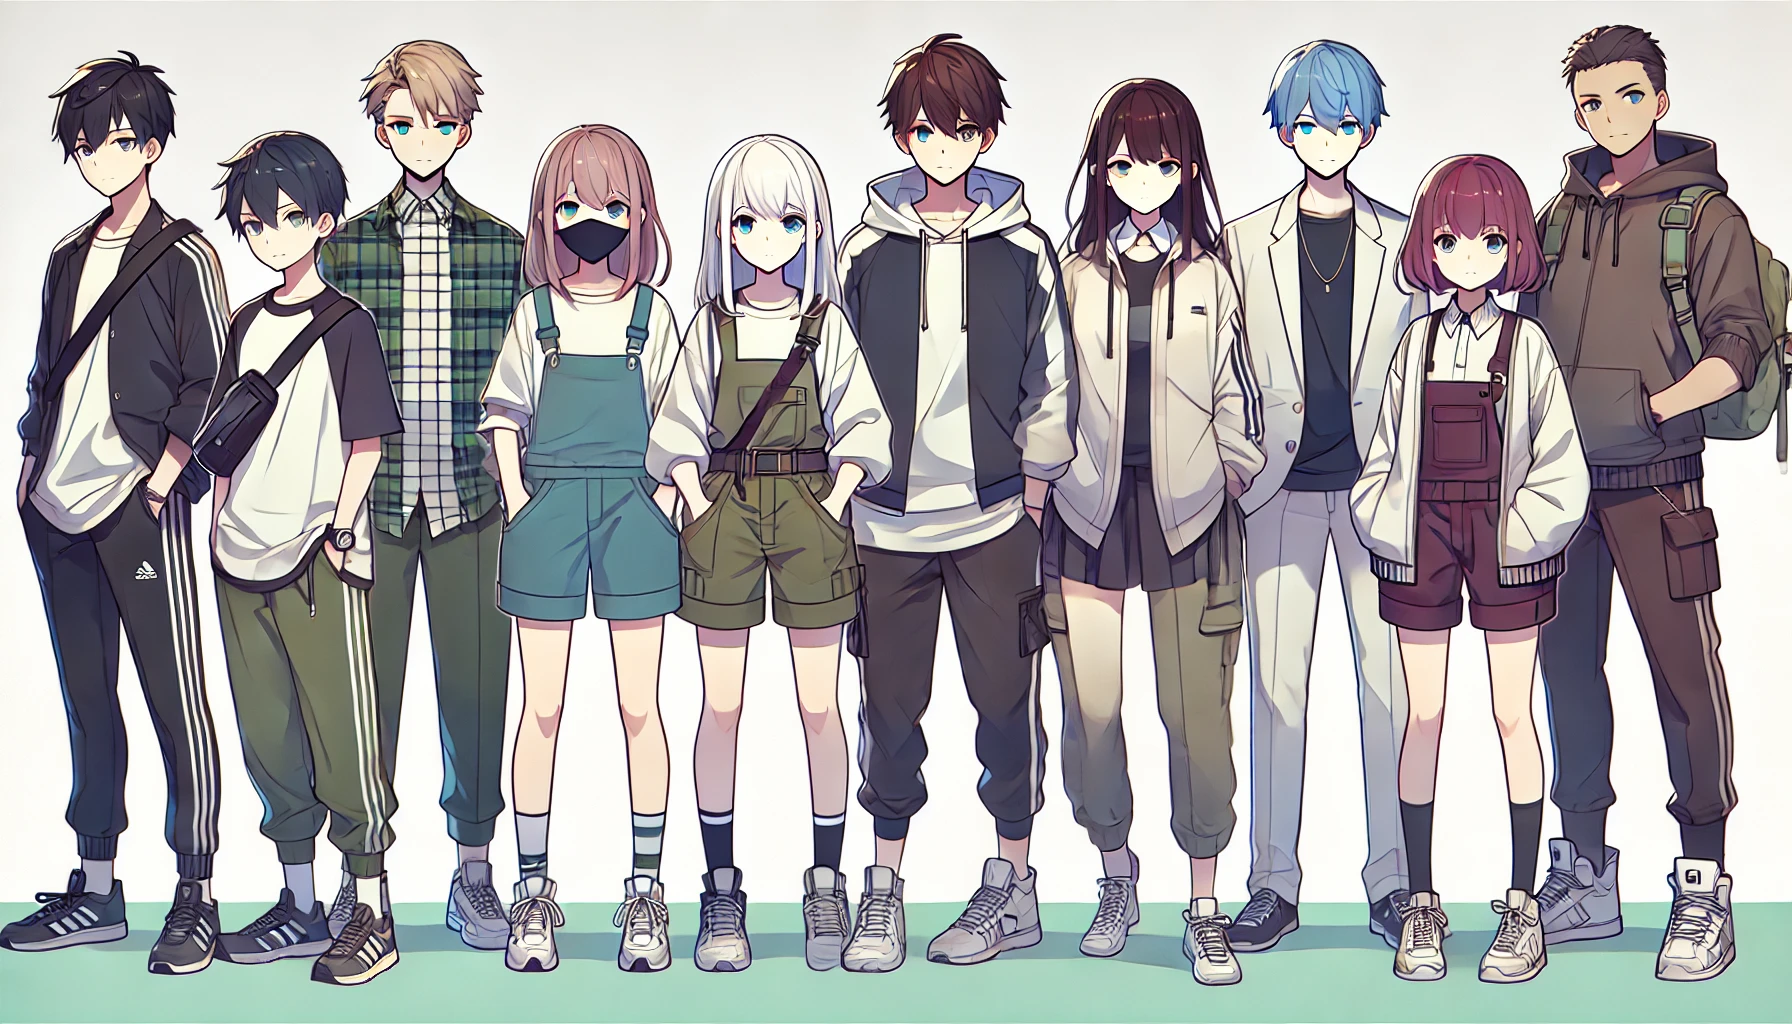

In [4]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread("CartoonSegmentationOnnx-Colaboratory-Sample/docs/test.webp")
cv2_imshow(image)

# モデル読み込み

In [5]:
from CartoonSegmentationOnnx.src.pipe import Pipe

cartoon_segmentation_pipe = Pipe(
    base_model_path="CartoonSegmentationOnnx/models/base.onnx",
    refiner_mode_path="CartoonSegmentationOnnx/models/refiner.onnx",
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

In [6]:
print(cartoon_segmentation_pipe.base_model.session .get_providers())
print(cartoon_segmentation_pipe.refiner_model.session .get_providers())

['CUDAExecutionProvider', 'CPUExecutionProvider']
['CUDAExecutionProvider', 'CPUExecutionProvider']


# 推論

In [ ]:
# ウォームアップ
_ = cartoon_segmentation_pipe._infer(image, instance_threshold=0.3, mask_threshold=0.6)

In [ ]:
%%time
results = cartoon_segmentation_pipe._infer(image, instance_threshold=0.3, mask_threshold=0.6)

# 結果確認

In [8]:
import copy
import numpy as np

def color_generator():
    colors = [
        (255, 16, 16), (16, 255, 16), (255, 240, 16), (16, 15, 255), (0, 24, 236), (255, 56, 56), (255, 157, 151),
        (255, 112, 31), (255, 178, 29), (207, 210, 49), (72, 249, 10), (146, 204, 23), (61, 219, 134), (26, 147, 52),
        (0, 212, 187), (44, 153, 168), (0, 194, 255), (52, 69, 147), (100, 115, 255), (0, 24, 236), (132, 56, 255),
        (82, 0, 133), (203, 56, 255), (255, 149, 200), (255, 55, 199),
    ]
    while True:
        for color in colors:
            yield color
color_gen = color_generator()

debug_image = copy.deepcopy(image)
for result in results:
    bbox, score, mask = result
    color = next(color_gen)

    color_mask = np.zeros_like(debug_image)
    color_mask[mask] = color
    debug_image = cv2.addWeighted(debug_image, 1, color_mask, 0.5, 1)

    cv2.rectangle(debug_image, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
    cv2.putText(
        debug_image,
        f"Score: {score:.2f}",
        (bbox[0], bbox[1] - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        color,
        1,
    )

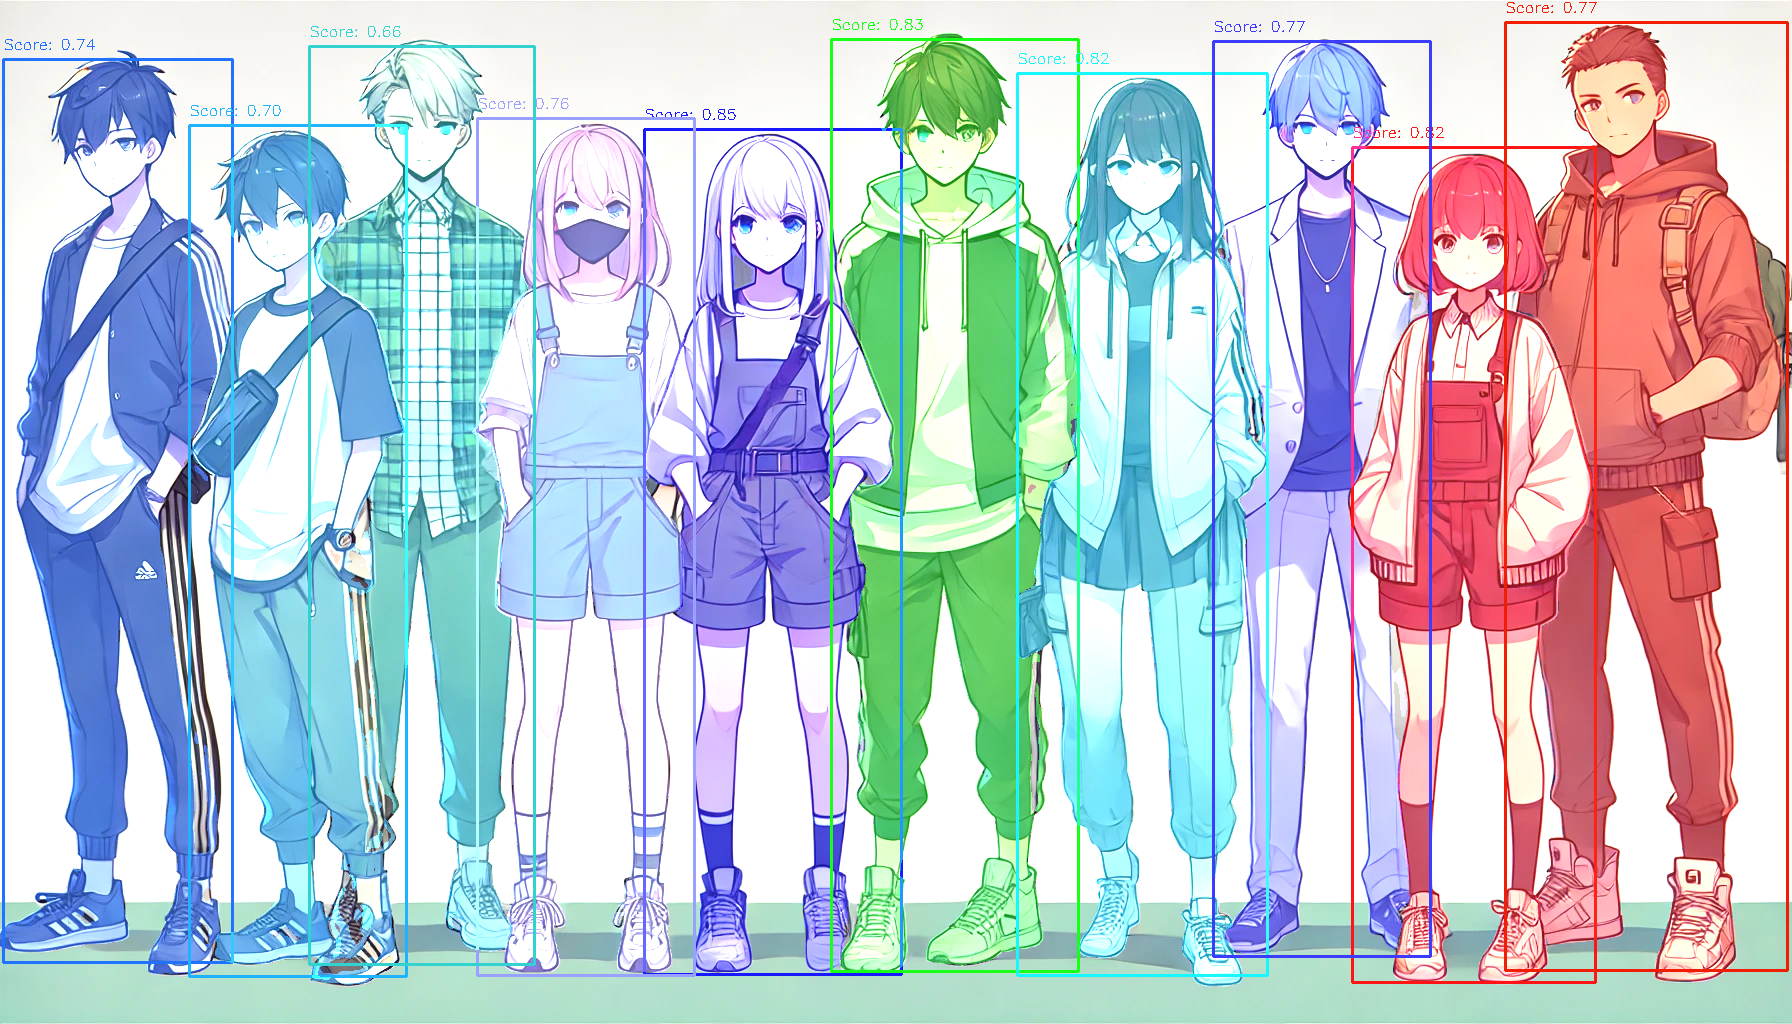

In [9]:
import cv2
from google.colab.patches import cv2_imshow

cv2_imshow(debug_image)